In [1]:
import sys
import pickle
from collections import defaultdict

from matplotlib import colors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from networkx.algorithms.approximation import clique
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklearn.preprocessing import Normalizer
from tqdm.notebook import tqdm

from utils import SBM_Data, Datasets_Data, load_or_calc_and_save, ytrue_to_partition, calc_avranks, RFE, RFE_LOO, OneVsRest_custom, OneHotEncoding_custom

sys.path.append('../../pygkernels')
from pygkernels.scenario import d3_category20

In [2]:
data_hub = SBM_Data()
_, results_modularity_any3, modularity_results = data_hub.load_precalculated()

X, y = data_hub.make_dataset()
X_train, y_train = X[:, :70].reshape(-1, 22), y[:, :70].reshape(-1, 25)
X_val,   y_val   = X[:, 70:].reshape(-1, 22), y[:, 70:].reshape(-1, 25)
X,       y       = X.reshape(-1, 22), y.reshape(-1, 25)

_, y_ari = data_hub.make_dataset(return_clf=False)
ari_train = y_ari[:, :70].reshape(-1, 25)
ari_val = y_ari[:, 70:].reshape(-1, 25)

feature_names = data_hub.allowed_features_list

prepare columns: 100%|██████████| 86/86 [00:00<00:00, 458.45it/s]


In [3]:
data_hub.kernel_names.index('SCT')

10

# Baseline 1: the best measure for all

In [4]:
by_kernel_results = dict(zip(data_hub.kernel_names, np.mean(ari_val, axis=0)))
df = pd.DataFrame(list(by_kernel_results.items()), columns=['measure', 'mean ari'])
df.sort_values('mean ari', ascending=False)

,measure,mean ari
7,logHeat,0.682207
10,SCT,0.679357
11,SCCT,0.676275
6,Heat,0.674940
3,logFor,0.670327
17,logModifPPR,0.661888
19,logHeatPR,0.659640
12,RSP,0.659491
9,logNHeat,0.658873
15,logPPR,0.657278


In [5]:
baseline = list(df.iloc[7])[1]
baseline

0.6822066926711716

# Baseline2: best measure for every column 

In [6]:
by_column_results = defaultdict(list)
for column_name, column_results in results_modularity_any3.items():
    by_kernel_results = defaultdict(list)
    for graph_idx, graph_results in column_results.items():
        for kernel_name, kernel_result in graph_results.items():
            by_kernel_results[kernel_name].append(kernel_result)
    best_measure, best_ari = sorted([(k, np.mean(v)) for k, v in by_kernel_results.items()], key=lambda x: -x[1])[0]
    by_column_results[column_name] = (best_measure, best_ari)

df = pd.DataFrame([(k, v[0], v[1]) for k, v in by_column_results.items()], columns=['column', 'best_measure', 'mean ari'])
upper_bound1 = np.mean(list(df['mean ari']))
upper_bound1

0.7005810530473514

# Upper bound: best measure for every graph

In [7]:
results = list()
for column_name, column_results in results_modularity_any3.items():
    for graph_idx, graph_results in column_results.items():
        graph_best_ari = np.max(list(graph_results.values()))
        results.append(graph_best_ari)

upper_bound2 = np.mean(results)
upper_bound2

0.7386917036110954

# Ours #1 (logRegression)

In [8]:
estimator = OneVsRestClassifier(LogisticRegression())
estimator.fit(X_train[:, [6, 18]], y_train)
y_pred = estimator.predict_proba(X_val[:, [6, 18]])
ours1 = np.mean(ari_val[range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours1

0.6777481329499893

# Ours #2: choose measure by algo

In [9]:
estimator = OneVsRestClassifier(SVC(probability=True))
estimator.fit(X_train[:, [6, 18]], y_train)
y_pred = estimator.predict_proba(X_val[:, [6, 18]])

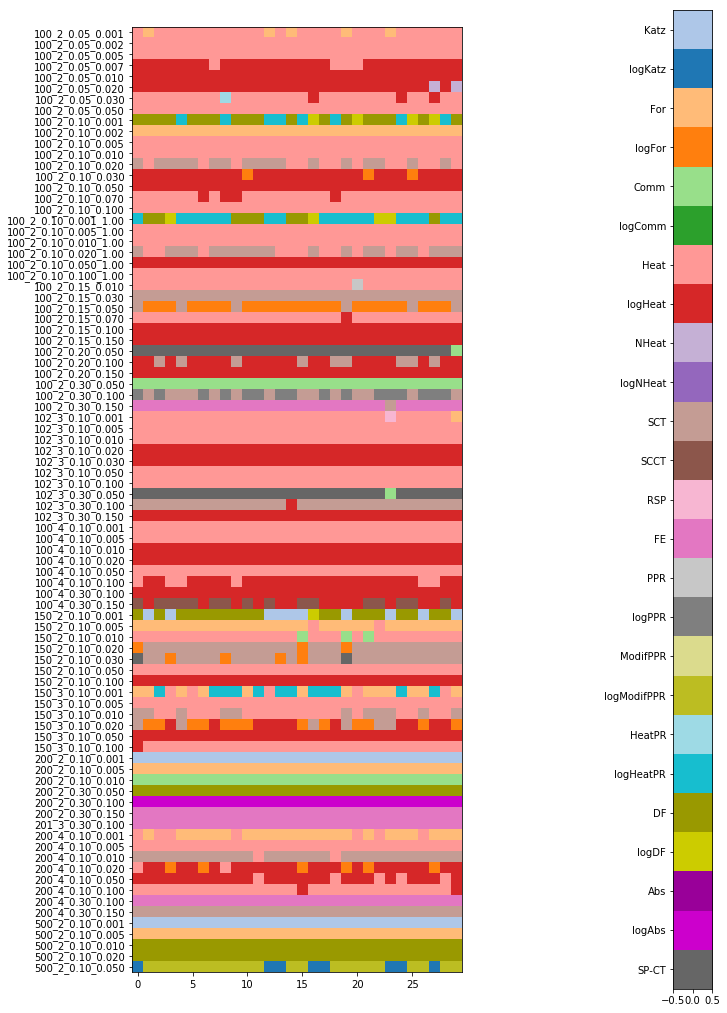

In [10]:
every_graph_choice = np.argmax(y_pred, axis=1).reshape(-1, 30)
every_graph_choice_pic = np.zeros((every_graph_choice.shape[0], 30, 3))

for i in range(every_graph_choice.shape[0]):
    for j in range(every_graph_choice.shape[1]):
        every_graph_choice_pic[i, j] = np.array(colors.hex2color(d3_category20[every_graph_choice[i, j]]))
        
fig, ax = plt.subplots(1, 2, figsize=(13, 18))
ax[0].imshow(every_graph_choice_pic)
ax[0].set_yticks(range(len(data_hub.datasets)))
ax[0].set_yticklabels(data_hub.datasets);

ax[1].imshow(np.array([colors.hex2color(d3_category20[i]) for i in range(25)])[:, None])
ax[1].set_yticks(range(len(data_hub.kernel_names)))
ax[1].set_yticklabels(data_hub.kernel_names);

In [11]:
ours2 = np.mean(ari_val[range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours2

0.6878350324599658

# Ours #3 (filter out kernels)

In [12]:
support_kernels = np.array([False, True, True, True, False, True, True, True, False,
                            False, True, True, True, False, False, False, True, True,
                            True, True, False, False, False, False, True])

In [13]:
estimator = OneVsRestClassifier(SVC(probability=True))
estimator.fit(X_train[:, [6, 18]], y_train[:, support_kernels])
y_pred = estimator.predict_proba(X_val[:, [6, 18]])
ours3 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours3

0.6870900730311091

# Ours #4 (own OneVsRest)

In [14]:
estimator = OneVsRest_custom(SVC(), weight_samples=False)
estimator.fit(X_train[:, [6, 18]], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours4 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours4

0.6545587092882291

# Ours #5 (sample weights)

In [15]:
estimator = OneVsRest_custom(SVC(), weight_samples=True)
estimator.fit(X_train[:, [6, 18]], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours5 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours5

0.6521655184750695

# Ours #6 (SVR)

In [16]:
estimator = OneVsRest_custom(SVR(), weight_samples=False)
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours6 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours6

0.6863203112249476

# Ours # 7 (SVR, sample weights)

In [17]:
estimator = OneVsRest_custom(SVR(), weight_samples=True)
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours7 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours7

0.6880358265894039

# Ours #8 (SVR, sample weights, normalized to max)

In [18]:
estimator = OneVsRest_custom(SVR(), weight_samples=True)
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels] / np.max(ari_train[:, support_kernels], axis=1, keepdims=1))
y_pred = estimator.predict(X_val[:, [6, 18]])
ours8 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours8

0.6879026723440368

# Ours #9 (RandomForestClassifier, sample_weights)

In [19]:
estimator = RandomForestClassifier()
estimator.fit(X_train[:, [6, 18]], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours9 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours9

0.6779380700194221

# Ours #10 (RandomForestRegressor, sample_weights)

In [20]:
estimator = RandomForestRegressor()
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours10 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours10

0.6874081671241801

# Ours #11 (KNeighborsClassifier)

In [21]:
estimator = OneVsRest_custom(KNeighborsClassifier(n_neighbors=5), weight_samples=False)
estimator.fit(X_train[:, [6, 18]], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours11 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours11

0.6693455131951032

# Ours #12 (KNeighborsRegressor)

In [22]:
estimator = OneVsRest_custom(KNeighborsRegressor(n_neighbors=5), weight_samples=False)
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours12 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours12

0.6927817974430417

# Ours #13 (LinearSVC)

In [23]:
estimator = OneVsRest_custom(LinearSVC(), weight_samples=True)
estimator.fit(X_train[:, [6, 18]], y_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours13 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours13

0.651603331892544

# Ours #14 (LinearSVR)

In [24]:
estimator = OneVsRest_custom(LinearSVR(), weight_samples=True)
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours14 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours14

0.6823667454853042

# Ours #15 (OneHotEncoding(SVR))

In [25]:
estimator = OneHotEncoding_custom(SVR(), weight_samples=False)
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours15 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours15

0.6878630140897283

# Ours #16 (OneHotEncoding(SVR), sample_weights)

In [ ]:
estimator = OneHotEncoding_custom(SVR(), weight_samples=True)
estimator.fit(X_train[:, [6, 18]], ari_train[:, support_kernels])
y_pred = estimator.predict(X_val[:, [6, 18]])
ours16 = np.mean(ari_val[:, support_kernels][range(y_pred.shape[0]), np.argmax(y_pred, axis=1)])
ours16

# Summary

In [26]:
df = pd.DataFrame([
    (-1,'baseline', baseline),
    (1, 'OneVsRest(logRegression)', ours1),
    (2, 'OneVsRest(SVC)', ours2),
    (3, 'OneVsRest(SVC), filter kernels', ours3),
    (4, 'separate(SVC), filter kernels', ours4),
    (5, 'separate(SVC), filter kernels, weight samples', ours5),
    (6, 'separate(SVR), filter kernels', ours6),
    (7, 'separate(SVR), filter kernels, weight samples', ours7),
    (8, 'separate(SVR), filter kernels, weight samples, normalized', ours8),
    (9, 'RandomForestClassifier, filter kernels', ours9),
    (10, 'RandomForestRegressor, filter kernels', ours10),
    (11, 'separate(KNeighborsClassifier), filter kernels', ours11),
    (12, 'separate(KNeighborsRegressor), filter kernels', ours12),
    (13, 'separate(LinearSVC), filter kernels, weight samples', ours13),
    (14, 'separate(LinearSVR), filter kernels, weight samples', ours14),
    (15, 'onehotencoding(SVR), filter kernels', ours15),
    (16, 'onehotencoding(SVR), filter kernels, weight samples', ours16),
    (-1, 'upper_bound1', upper_bound1),
    (-1, 'upper_bound2', upper_bound2)
], columns=['exp_no', 'method', 'ari'])
df.sort_values(by='ari', ascending=False)

,exp_no,method,ari
17,-1,upper_bound2,0.738692
16,-1,upper_bound1,0.700581
12,12,"separate(KNeighborsRegressor), filter kernels",0.692782
7,7,"separate(SVR), filter kernels, weight samples",0.688036
8,8,"separate(SVR), filter kernels, weight samples,...",0.687903
15,14,"onehotencoding(SVR), filter kernels",0.687863
2,2,OneVsRest(SVC),0.687835
10,10,"RandomForestRegressor, filter kernels",0.687408
3,3,"OneVsRest(SVC), filter kernels",0.687090
6,6,"separate(SVR), filter kernels",0.686320
